FileNotFoundError: [Errno 2] No such file or directory: 'D:\\shaojie\\NutsCloud\\Teach/trainData.pkl'

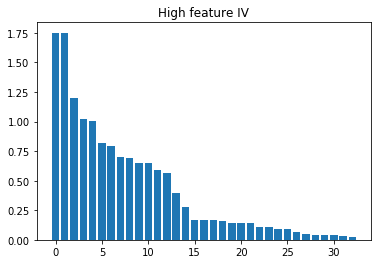

In [3]:
import pandas as pd
import numpy as np
import pickle
from statsmodels.stats.outliers_influence import variance_inflation_factor
import statsmodels.api as sm
from sklearn import ensemble
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import roc_auc_score

#################################
#由于数据已经经过一定的清洗了，非一手数据，所以我们忽略了一些步骤，进行变量衍生
#   1, 读取数据，衍生初始变量   #
'''
Loan_Amount:总额度
OS：未还金额
Payment：还款金额
Spend：使用金额
Delq：逾期情况
'''
#################################
#folderOfData = 'D:\\shaojie\\NutsCloud\\Teach'
#trainData = pd.read_csv(folderOfData+'/训练集.csv',header = 0,engine ='python')
#testData = pd.read_csv(folderOfData+'/测试集.csv',header = 0,engine ='python')
trainData = pd.read_csv('训练集.csv',header = 0,engine ='python')
testData = pd.read_csv('测试集.csv',header = 0,engine ='python')
print('1 --')

# 衍生逾期类型的特征的函数
def DelqFeatures(event,window,type):
    '''
    :parms event 数据框
    :parms windows 时间窗口
    :parms type 响应事件类型
    '''
    current = 12
    start = 12 - window + 1
    #delq1、delq2、delq3为了获取window相对应的dataframe范围
    delq1 = [event[a] for a in ['Delq1_' + str(t) for t in range(current, start - 1, -1)]]
    delq2 = [event[a] for a in ['Delq2_' + str(t) for t in range(current, start - 1, -1)]]
    delq3 = [event[a] for a in ['Delq3_' + str(t) for t in range(current, start - 1, -1)]]
    if type == 'max delq':
        if max(delq3) == 1:
            return 3
        elif max(delq2) == 1:
            return 2
        elif max(delq1) == 1:
            return 1
        else:
            return 0
    if type in ['M0 times','M1 times', 'M2 times']:
        if type.find('M0')>-1:
            return sum(delq1)
        elif type.find('M1')>-1:
            return sum(delq2)
        else:
            return sum(delq3)

allFeatures = []
 
'''
逾期类型的特征在行为评分卡（预测违约行为）中，一般是非常显著的变量。
通过设定时间窗口，可以衍生以下类型的逾期变量：
'''
print('2 --')
# 考虑过去1个月，3个月，6个月，12个月
for t in [1,3,6,12]:
    # 1，过去t时间窗口内的最大逾期状态
    allFeatures.append('maxDelqL'+str(t)+"M")
    trainData['maxDelqL'+str(t)+"M"] = trainData.apply(lambda x: DelqFeatures(x,t,'max delq'),axis=1)
 
    # 2，过去t时间窗口内的，M0,M1,M2的次数
    allFeatures.append('M0FreqL' + str(t) + "M")
    trainData['M0FreqL' + str(t) + "M"] = trainData.apply(lambda x: DelqFeatures(x,t,'M0 times'),axis=1)
 
    allFeatures.append('M1FreqL' + str(t) + "M")
    trainData['M1FreqL' + str(t) + "M"] = trainData.apply(lambda x: DelqFeatures(x, t, 'M1 times'), axis=1)
 
    allFeatures.append('M2FreqL' + str(t) + "M")
    trainData['M2FreqL' + str(t) + "M"] = trainData.apply(lambda x: DelqFeatures(x, t, 'M2 times'), axis=1)

print('2 Done')

#衍生额度使用率类型特征的函数
def UrateFeatures(event, window, type):
    '''
    :parms event 数据框
    :parms windows 时间窗口
    :parms type 响应事件类型
    '''
    current = 12
    start = 12 - window + 1
    #获取在数据框内有效区域
    monthlySpend = [event[a] for a in ['Spend_' + str(t) for t in range(current, start - 1, -1)]]
    #获取授信总额度
    limit = event['Loan_Amount']
    #月使用率
    monthlyUrate = [x / limit for x in monthlySpend]
    if type == 'mean utilization rate':
        return np.mean(monthlyUrate)
    if type == 'max utilization rate':
        return max(monthlyUrate)
    #月额度使用率增加的月份
    if type == 'increase utilization rate':
        #val[0:-1]表示第一个元素到倒数第二个元素的切片
        currentUrate = monthlyUrate[0:-1]
        #val[1:]表示第二个元素到最后一个元素的切片
        previousUrate = monthlyUrate[1:]
        compareUrate = [int(x[0]>x[1]) for x in zip(currentUrate,previousUrate)]
        return sum(compareUrate)

print('3 --')
'''
额度使用率类型特征在行为评分卡模型中，通常是与违约高度相关的
'''
# 考虑过去1个月，3个月，6个月，12个月
for t in [1,3,6,12]:
    # 1，过去t时间窗口内的最大月额度使用率
    allFeatures.append('maxUrateL' + str(t) + "M")
    trainData['maxUrateL' + str(t) + "M"] = trainData.apply(lambda x: UrateFeatures(x,t,'max utilization rate'),axis = 1)
 
    # 2，过去t时间窗口内的平均月额度使用率
    allFeatures.append('avgUrateL' + str(t) + "M")
    trainData['avgUrateL' + str(t) + "M"] = trainData.apply(lambda x: UrateFeatures(x, t, 'mean utilization rate'),axis=1)
 
    # 3，过去t时间窗口内，月额度使用率增加的月份。该变量要求t>1
    if t > 1:
        allFeatures.append('increaseUrateL' + str(t) + "M")
        trainData['increaseUrateL' + str(t) + "M"] = trainData.apply(lambda x: UrateFeatures(x, t, 'increase utilization rate'),axis=1)
print('3 Done')

#衍生还款类型特征的函数
def PaymentFeatures(event, window, type):
    current = 12
    start = 12 - window + 1
    #月还款金额
    currentPayment = [event[a] for a in ['Payment_' + str(t) for t in range(current, start - 1, -1)]]
    #月使用金额，错位一下
    previousOS = [event[a] for a in ['OS_' + str(t) for t in range(current-1, start - 2, -1)]]
    monthlyPayRatio = []
    for Pay_OS in zip(currentPayment,previousOS):
        #前一个月使用了才会产生还款
        if Pay_OS[1]>0:
            payRatio = Pay_OS[0]*1.0 / Pay_OS[1]
            monthlyPayRatio.append(payRatio)
        #前一个月没使用，就按照100%还款
        else:
            monthlyPayRatio.append(1)
    if type == 'min payment ratio':
        return min(monthlyPayRatio)
    if type == 'max payment ratio':
        return max(monthlyPayRatio)
    if type == 'mean payment ratio':
        total_payment = sum(currentPayment)
        total_OS = sum(previousOS)
        if total_OS > 0:
            return total_payment / total_OS
        else:
            return 1
print('4 --')
'''
还款类型特征也是行为评分卡模型中常用的特征
'''
# 考虑过去1个月，3个月，6个月，12个月
for t in [1,3,6,12]:
    # 1，过去t时间窗口内的最大月还款率
    allFeatures.append('maxPayL' + str(t) + "M")
    trainData['maxPayL' + str(t) + "M"] = trainData.apply(lambda x: PaymentFeatures(x, t, 'max payment ratio'),axis=1)
    # 2，过去t时间窗口内的最小月还款率
    allFeatures.append('minPayL' + str(t) + "M")
    trainData['minPayL' + str(t) + "M"] = trainData.apply(lambda x: PaymentFeatures(x, t, 'min payment ratio'),axis=1)
    # 3，过去t时间窗口内的平均月还款率
    allFeatures.append('avgPayL' + str(t) + "M")
    trainData['avgPayL' + str(t) + "M"] = trainData.apply(lambda x: PaymentFeatures(x, t, 'mean payment ratio'),axis=1)

print('4 Done')

###函数########
#计算变量分箱之后各分箱的坏样本率
def BinBadRate(df, col, target, grantRateIndicator=0):
    '''
    :param df: 需要计算好坏比率的数据集
    :param col: 需要计算好坏比率的特征
    :param target: 好坏标签
    :param grantRateIndicator: 1返回总体的坏样本率，0不返回
    :return: 每箱的坏样本率，以及总体的坏样本率（当grantRateIndicator＝＝1时）
    '''
    #print(df.groupby([col])[target])
    total = df.groupby([col])[target].count()
    #print(total)
    total = pd.DataFrame({'total': total})
    #print(total)
    bad = df.groupby([col])[target].sum()
    bad = pd.DataFrame({'bad': bad})
    #合并
    regroup = total.merge(bad, left_index=True, right_index=True, how='left')
    #print(regroup)
    regroup.reset_index(level=0, inplace=True)
    #print(regroup)
    #计算坏样本率
    regroup['bad_rate'] = regroup.apply(lambda x: x.bad * 1.0 / x.total, axis=1)
    #print(regroup)
    #生成字典，（变量名取值：坏样本率）
    dicts = dict(zip(regroup[col],regroup['bad_rate']))
    if grantRateIndicator==0:
        return (dicts, regroup)
    N = sum(regroup['total'])
    B = sum(regroup['bad'])
    #总体样本率
    overallRate = B * 1.0 / N
    return (dicts, regroup, overallRate)


## 判断某变量的坏样本率是否单调
def BadRateMonotone(df, sortByVar, target,special_attribute = []):
    '''
    :param df: 包含检验坏样本率的变量，和目标变量
    :param sortByVar: 需要检验坏样本率的变量
    :param target: 目标变量，0、1表示好、坏
    :param special_attribute: 不参与检验的特殊值
    :return: 坏样本率单调与否
    '''
    df2 = df.loc[~df[sortByVar].isin(special_attribute)]
    if len(set(df2[sortByVar])) <= 2:
        return True
    regroup = BinBadRate(df2, sortByVar, target)[1]
    combined = zip(regroup['total'],regroup['bad'])
    badRate = [x[1]*1.0/x[0] for x in combined]
    badRateNotMonotone = [badRate[i]<badRate[i+1] and badRate[i] < badRate[i-1] or badRate[i]>badRate[i+1] and badRate[i] > badRate[i-1]
                          for i in range(1,len(badRate)-1)]
    if True in badRateNotMonotone:
        return False
    else:
        return True

print('5 --')
############################
#   2, 分箱，计算WOE并编码   #
############################

'''
对类别型变量的分箱和WOE计算
可以通过计算取值个数的方式判断是否是类别型变量
'''
#类别型变量
categoricalFeatures = []
#连续型变量
numericalFeatures = []
WOE_IV_dict = {}
for var in allFeatures:
    if len(set(trainData[var])) > 5:
        numericalFeatures.append(var)
    else:
        categoricalFeatures.append(var)

not_monotone =[]
for var in categoricalFeatures:
    #检查bad rate在箱中的单调性
    if not BadRateMonotone(trainData, var, 'label'):
        not_monotone.append(var)

#print("数值取值小于5类别型变量{}坏样本率不单调".format(not_monotone))
 
# 'M1FreqL3M'，'M2FreqL3M', 'maxDelqL12M' 是不单调的，需要合并其中某些类别
trainData.groupby(['M2FreqL3M'])['label'].mean()  #检查单调性
trainData.groupby(['M2FreqL3M'])['label'].count()   #其中，M2FreqL3M＝3总共只有3个样本，因此要进行合并
 
 
 
# 将 M2FreqL3M>=1的合并为一组，计算WOE和IV
trainData['M2FreqL3M_Bin'] = trainData['M2FreqL3M'].apply(lambda x: int(x>=1))
trainData.groupby(['M2FreqL3M_Bin'])['label'].mean()

print('5 Done')
 
#计算WOE值
def CalcWOE(df, col, target):
    '''
    :param df: 包含需要计算WOE的变量和目标变量
    :param col: 需要计算WOE、IV的变量，必须是分箱后的变量，或者不需要分箱的类别型变量
    :param target: 目标变量，0、1表示好、坏
    :return: 返回WOE和IV
    '''
    total = df.groupby([col])[target].count()
    total = pd.DataFrame({'total': total})
    bad = df.groupby([col])[target].sum()
    bad = pd.DataFrame({'bad': bad})
    regroup = total.merge(bad, left_index=True, right_index=True, how='left')
    regroup.reset_index(level=0, inplace=True)
    N = sum(regroup['total'])
    B = sum(regroup['bad'])
    regroup['good'] = regroup['total'] - regroup['bad']
    G = N - B
    regroup['bad_pcnt'] = regroup['bad'].map(lambda x: x*1.0/B)
    regroup['good_pcnt'] = regroup['good'].map(lambda x: x * 1.0 / G)
    regroup['WOE'] = regroup.apply(lambda x: np.log(x.good_pcnt*1.0/x.bad_pcnt),axis = 1)
    WOE_dict = regroup[[col,'WOE']].set_index(col).to_dict(orient='index')
    for k, v in WOE_dict.items():
        WOE_dict[k] = v['WOE']
    IV = regroup.apply(lambda x: (x.good_pcnt-x.bad_pcnt)*np.log(x.good_pcnt*1.0/x.bad_pcnt),axis = 1)
    IV = sum(IV)
    return {"WOE": WOE_dict, 'IV':IV}

print('6 --')
WOE_IV_dict['M2FreqL3M_Bin'] = CalcWOE(trainData, 'M2FreqL3M_Bin', 'label')
 
trainData.groupby(['M1FreqL3M'])['label'].mean()  #检查单调性
trainData.groupby(['M1FreqL3M'])['label'].count()
 
# 除了M1FreqL3M＝3外， 其他组别的bad rate单调。
# 此外，M1FreqL3M＝0 占比很大，因此将M1FreqL3M>=1的分为一组
trainData['M1FreqL3M_Bin'] = trainData['M1FreqL3M'].apply(lambda x: int(x>=1))
trainData.groupby(['M1FreqL3M_Bin'])['label'].mean()
WOE_IV_dict['M1FreqL3M_Bin'] = CalcWOE(trainData, 'M1FreqL3M_Bin', 'label')

'''
对其他单调的类别型变量，检查是否有一箱的占比低于5%。 如果有，将该变量进行合并
'''
small_bin_var = []
large_bin_var = []
N = trainData.shape[0]
for var in categoricalFeatures:
    if var not in not_monotone:
        total = trainData.groupby([var])[var].count()
        pcnt = total * 1.0 / N
        if min(pcnt)<0.05:
            small_bin_var.append({var:pcnt.to_dict()})
        else:
            large_bin_var.append(var)
 
 
#对于M2FreqL1M、M2FreqL6M和M2FreqL12M，由于有部分箱占了很大比例，故删除，因为样本表现99%都一样，这个变量没有区分度
allFeatures.remove('M2FreqL1M')
allFeatures.remove('M2FreqL6M')
allFeatures.remove('M2FreqL12M')

print('6 Done')

def MergeByCondition(x,condition_list):
    #condition_list是条件列表。满足第几个condition，就输出几
    s = 0
    for condition in condition_list:
        if eval(str(x)+condition):
            return s
        else:
            s+=1
    return s

print('7 --')

#对于small_bin_var中的其他变量，将最小的箱和相邻的箱进行合并并计算WOE
trainData['maxDelqL1M_Bin'] = trainData['maxDelqL1M'].apply(lambda x: MergeByCondition(x,['==0','==1','>=2']))
trainData['maxDelqL3M_Bin'] = trainData['maxDelqL3M'].apply(lambda x: MergeByCondition(x,['==0','==1','>=2']))
trainData['maxDelqL6M_Bin'] = trainData['maxDelqL6M'].apply(lambda x: MergeByCondition(x,['==0','==1','>=2']))
for var in ['maxDelqL1M_Bin','maxDelqL3M_Bin','maxDelqL6M_Bin']:
    WOE_IV_dict[var] = CalcWOE(trainData, var, 'label')
 
 
'''
对于不需要合并、原始箱的bad rate单调的特征，直接计算WOE和IV
'''
for var in large_bin_var:
    WOE_IV_dict[var] = CalcWOE(trainData, var, 'label')

print('7 Done')

def AssignBin(x, cutOffPoints,special_attribute=[]):
    '''
    :param x: 某个变量的某个取值
    :param cutOffPoints: 上述变量的分箱结果，用切分点表示
    :param special_attribute:  不参与分箱的特殊取值
    :return: 分箱后的对应的第几个箱，从0开始
    for example, if cutOffPoints = [10,20,30], if x = 7, return Bin 0. If x = 35, return Bin 3
    '''
    numBin = len(cutOffPoints) + 1 + len(special_attribute)
    if x in special_attribute:
        i = special_attribute.index(x)+1
        return 'Bin {}'.format(0-i)
    if x<=cutOffPoints[0]:
        return 'Bin 0'
    elif x > cutOffPoints[-1]:
        return 'Bin {}'.format(numBin-1)
    else:
        for i in range(0,numBin-1):
            if cutOffPoints[i] < x <=  cutOffPoints[i+1]:
                return 'Bin {}'.format(i+1)



def AssignGroup(x, bin):
    '''
    :param x: 某个变量的某个取值
    :param bin: 上述变量的分箱结果
    :return: x在分箱结果下的映射
    '''
    N = len(bin)
    if x<=min(bin):
        return min(bin)
    elif x>max(bin):
        return 10e10
    else:
        for i in range(N-1):
            if bin[i] < x <= bin[i+1]:
                return bin[i+1]
 
 
def SplitData(df, col, numOfSplit, special_attribute=[]):
    '''
    :param df: 按照col排序后的数据集
    :param col: 待分箱的变量
    :param numOfSplit: 切分的组别数
    :param special_attribute: 在切分数据集的时候，某些特殊值需要排除在外
    :return: 在原数据集上增加一列，把原始细粒度的col重新划分成粗粒度的值，便于分箱中的合并处理
    '''
    df2 = df.copy()
    if special_attribute != []:
        df2 = df.loc[~df[col].isin(special_attribute)]
    N = df2.shape[0]#行数
    #" / "就表示 浮点数除法，返回浮点结果;" // "表示整数除法
    n = N//numOfSplit #每组样本数
    splitPointIndex = [i*n for i in range(1,numOfSplit)] #分割点的下标
    '''
    [i*2 for i in range(1,100)]
    [2, 4, 6, 8, 10,......,198]
    '''
    rawValues = sorted(list(df2[col])) #对取值进行排序
    #取到粗糙卡方划分节点
    splitPoint = [rawValues[i] for i in splitPointIndex] #分割点的取值
    splitPoint = sorted(list(set(splitPoint)))
    return splitPoint


#计算卡方值的函数
def Chi2(df, total_col, bad_col, overallRate):
    '''
    :param df: 包含全部样本总计与坏样本总计的数据框
    :param total_col: 全部样本的个数
    :param bad_col: 坏样本的个数
    :param overallRate: 全体样本的坏样本占比
    :return: 卡方值
    '''
    df2 = df.copy()
    # 期望坏样本个数＝全部样本个数*平均坏样本占比
    df2['expected'] = df[total_col].apply(lambda x: x*overallRate)
    combined = zip(df2['expected'], df2[bad_col])
    chi = [(i[0]-i[1])**2/i[0] for i in combined]
    chi2 = sum(chi)
    return chi2


##ChiMerge_MaxInterval：通过指定最大间隔数，使用卡方值分割连续变量
def ChiMerge(df, col, target, max_interval=5,special_attribute=[],minBinPcnt=0):
    '''
    :param df: 包含目标变量与分箱属性的数据框
    :param col: 需要分箱的属性
    :param target: 目标变量，取值0或1
    :param max_interval: 最大分箱数。如果原始属性的取值个数低于该参数，不执行这段函数
    :param special_attribute: 不参与分箱的属性取值，缺失值的情况
    :param minBinPcnt：最小箱的占比，默认为0
    :return: 分箱结果
    '''
    colLevels = sorted(list(set(df[col])))
    N_distinct = len(colLevels)#不同的取值个数
    if N_distinct <= max_interval:  #如果原始属性的取值个数低于max_interval，不执行这段函数
        print ("原始属性{}的取值个数低于max_interval".format(col))
        #分箱分数间隔段，少一个值也可以
        #返回值colLevels会少一个最大值
        return colLevels[:-1]
    else:
        if len(special_attribute)>=1:
            #df1数据框取trainData中col那一列为特殊值的数据集
            #df1 = df.loc[df[col].isin(special_attribute)]
            print('{} 有缺失值的情况'.format(col))
            #用逆函数对筛选后的结果取余，起删除指定行作用
            df2 = df.loc[~df[col].isin(special_attribute)]
        else:
            df2 = df.copy()
        N_distinct = len(list(set(df2[col])))#该特征不同的取值
 
        # 步骤一: 通过col对数据集进行分组，求出每组的总样本数与坏样本数
        if N_distinct > 100:
            '''
            split_x样例
            [2, 8, 9.3 , 1 0, 30 ,......,1800]
            '''
            split_x = SplitData(df2, col, 100)
            #把值变为划分点的值
            df2['temp'] = df2[col].map(lambda x: AssignGroup(x, split_x))
        else:
            #假如数值取值小于100就不发生变化了
            df2['temp'] = df2[col]
        # 总体bad rate将被用来计算expected bad count
        (binBadRate, regroup, overallRate) = BinBadRate(df2, 'temp', target, grantRateIndicator=1)
 
        # 首先，每个单独的属性值将被分为单独的一组
        # 对属性值进行排序，然后两两组别进行合并
        colLevels = sorted(list(set(df2['temp'])))
        groupIntervals = [[i] for i in colLevels]
 
        # 步骤二：建立循环，不断合并最优的相邻两个组别，直到：
        # 1，最终分裂出来的分箱数<＝预设的最大分箱数
        # 2，每箱的占比不低于预设值（可选）
        # 3，每箱同时包含好坏样本
        # 如果有特殊属性，那么最终分裂出来的分箱数＝预设的最大分箱数－特殊属性的个数
        split_intervals = max_interval - len(special_attribute)
        while (len(groupIntervals) > split_intervals):  # 终止条件: 当前分箱数＝预设的分箱数
            # 每次循环时, 计算合并相邻组别后的卡方值。具有最小卡方值的合并方案，是最优方案
            #存储卡方值
            chisqList = []
            for k in range(len(groupIntervals)-1):
                temp_group = groupIntervals[k] + groupIntervals[k+1]
                df2b = regroup.loc[regroup['temp'].isin(temp_group)]
                chisq = Chi2(df2b, 'total', 'bad', overallRate)
                chisqList.append(chisq)
            best_comnbined = chisqList.index(min(chisqList))
            groupIntervals[best_comnbined] = groupIntervals[best_comnbined] + groupIntervals[best_comnbined+1]
            # after combining two intervals, we need to remove one of them
            groupIntervals.remove(groupIntervals[best_comnbined+1])
        groupIntervals = [sorted(i) for i in groupIntervals]
        cutOffPoints = [max(i) for i in groupIntervals[:-1]]
 
        # 检查是否有箱没有好或者坏样本。如果有，需要跟相邻的箱进行合并，直到每箱同时包含好坏样本
        groupedvalues = df2['temp'].apply(lambda x: AssignBin(x, cutOffPoints))
        #已成完成卡方分箱，但是没有考虑其单调性
        df2['temp_Bin'] = groupedvalues
        (binBadRate,regroup) = BinBadRate(df2, 'temp_Bin', target)
        [minBadRate, maxBadRate] = [min(binBadRate.values()),max(binBadRate.values())]
        while minBadRate ==0 or maxBadRate == 1:
            # 找出全部为好／坏样本的箱
            indexForBad01 = regroup[regroup['bad_rate'].isin([0,1])].temp_Bin.tolist()
            bin=indexForBad01[0]
            # 如果是最后一箱，则需要和上一个箱进行合并，也就意味着分裂点cutOffPoints中的最后一个需要移除
            if bin == max(regroup.temp_Bin):
                cutOffPoints = cutOffPoints[:-1]
            # 如果是第一箱，则需要和下一个箱进行合并，也就意味着分裂点cutOffPoints中的第一个需要移除
            elif bin == min(regroup.temp_Bin):
                cutOffPoints = cutOffPoints[1:]
            # 如果是中间的某一箱，则需要和前后中的一个箱进行合并，依据是较小的卡方值
            else:
                # 和前一箱进行合并，并且计算卡方值
                currentIndex = list(regroup.temp_Bin).index(bin)
                prevIndex = list(regroup.temp_Bin)[currentIndex - 1]
                df3 = df2.loc[df2['temp_Bin'].isin([prevIndex, bin])]
                (binBadRate, df2b) = BinBadRate(df3, 'temp_Bin', target)
                chisq1 = Chi2(df2b, 'total', 'bad', overallRate)
                # 和后一箱进行合并，并且计算卡方值
                laterIndex = list(regroup.temp_Bin)[currentIndex + 1]
                df3b = df2.loc[df2['temp_Bin'].isin([laterIndex, bin])]
                (binBadRate, df2b) = BinBadRate(df3b, 'temp_Bin', target)
                chisq2 = Chi2(df2b, 'total', 'bad', overallRate)
                if chisq1 < chisq2:
                    cutOffPoints.remove(cutOffPoints[currentIndex - 1])
                else:
                    cutOffPoints.remove(cutOffPoints[currentIndex])
            # 完成合并之后，需要再次计算新的分箱准则下，每箱是否同时包含好坏样本
            groupedvalues = df2['temp'].apply(lambda x: AssignBin(x, cutOffPoints))
            df2['temp_Bin'] = groupedvalues
            (binBadRate, regroup) = BinBadRate(df2, 'temp_Bin', target)
            [minBadRate, maxBadRate] = [min(binBadRate.values()), max(binBadRate.values())]
 
        # 需要检查分箱后的最小占比
        if minBinPcnt > 0:
            groupedvalues = df2['temp'].apply(lambda x: AssignBin(x, cutOffPoints))
            df2['temp_Bin'] = groupedvalues
            #value_counts每个数值出现了多少次
            valueCounts = groupedvalues.value_counts().to_frame()
            N=sum(valueCounts['temp'])
            valueCounts['pcnt'] = valueCounts['temp'].apply(lambda x: x * 1.0 / N)
            valueCounts = valueCounts.sort_index()
            minPcnt = min(valueCounts['pcnt'])
            #一定要箱数大于2才可以，要不就不能再合并了
            while minPcnt < minBinPcnt and len(cutOffPoints) > 2:
                # 找出占比最小的箱
                indexForMinPcnt = valueCounts[valueCounts['pcnt'] == minPcnt].index.tolist()[0]
                # 如果占比最小的箱是最后一箱，则需要和上一个箱进行合并，也就意味着分裂点cutOffPoints中的最后一个需要移除
                if indexForMinPcnt == max(valueCounts.index):
                    cutOffPoints = cutOffPoints[:-1]
                # 如果占比最小的箱是第一箱，则需要和下一个箱进行合并，也就意味着分裂点cutOffPoints中的第一个需要移除
                elif indexForMinPcnt == min(valueCounts.index):
                    cutOffPoints = cutOffPoints[1:]
                # 如果占比最小的箱是中间的某一箱，则需要和前后中的一个箱进行合并，依据是较小的卡方值
                else:
                    # 和前一箱进行合并，并且计算卡方值
                    currentIndex = list(valueCounts.index).index(indexForMinPcnt)
                    prevIndex = list(valueCounts.index)[currentIndex - 1]
                    df3 = df2.loc[df2['temp_Bin'].isin([prevIndex, indexForMinPcnt])]
                    (binBadRate, df2b) = BinBadRate(df3, 'temp_Bin', target)
                    chisq1 = Chi2(df2b, 'total', 'bad', overallRate)
                    # 和后一箱进行合并，并且计算卡方值
                    laterIndex = list(valueCounts.index)[currentIndex + 1]
                    df3b = df2.loc[df2['temp_Bin'].isin([laterIndex, indexForMinPcnt])]
                    (binBadRate, df2b) = BinBadRate(df3b, 'temp_Bin', target)
                    chisq2 = Chi2(df2b, 'total', 'bad', overallRate)
                    if chisq1 < chisq2:
                        cutOffPoints.remove(cutOffPoints[currentIndex - 1])
                    else:
                        cutOffPoints.remove(cutOffPoints[currentIndex])
        cutOffPoints = special_attribute + cutOffPoints
        return cutOffPoints


'''
对于数值型变量，需要先分箱，再计算WOE、IV
分箱的结果需要满足：
1，箱数不超过5
2，bad rate单调
3，每箱占比不低于5%
'''
bin_dict = []
for var in numericalFeatures:
    binNum = 5
    newBin = var + '_Bin'
    bin = ChiMerge(trainData, var, 'label',max_interval=binNum,minBinPcnt = 0.05)
    trainData[newBin] = trainData[var].apply(lambda x: AssignBin(x,bin))
    # 如果不满足单调性，就降低分箱个数
    while not BadRateMonotone(trainData, newBin, 'label'):
        binNum -= 1
        bin = ChiMerge(trainData, var, 'label', max_interval=binNum, minBinPcnt=0.05)
        trainData[newBin] = trainData[var].apply(lambda x: AssignBin(x, bin))
    WOE_IV_dict[newBin] = CalcWOE(trainData, newBin, 'label')
    bin_dict.append({var:bin})



##############################
#   3, 单变量分析和多变量分析   #
##############################
#  选取IV高于0.02的变量
high_IV = [(k,v['IV']) for k,v in WOE_IV_dict.items() if v['IV'] >= 0.02]
high_IV_sorted = sorted(high_IV, key=lambda k: k[1],reverse=True)
IV_values = [i[1] for i in high_IV_sorted]
IV_name = [i[0] for i in high_IV_sorted]
plt.title('High feature IV')
plt.bar(range(len(IV_values)),IV_values)


for (var,iv) in high_IV:
    newVar = var+"_WOE"
    trainData[newVar] = trainData[var].map(lambda x: WOE_IV_dict[var]['WOE'][x])


saveFile = open('trainData.pkl','wb+')
pickle.dump(trainData,saveFile)
saveFile.close()


saveFile = open('trainData.pkl','rb+')
trainData = pickle.load(saveFile)
saveFile.close()



'''
多变量分析：比较两两线性相关性。如果相关系数的绝对值高于阈值，剔除IV较低的一个
'''
deleted_index = []
cnt_vars = len(high_IV_sorted)
for i in range(cnt_vars):
    if i in deleted_index:
        continue
    x1 = high_IV_sorted[i][0]+"_WOE"
    for j in range(cnt_vars):
        if i == j or j in deleted_index:
            continue
        y1 = high_IV_sorted[j][0]+"_WOE"
        roh = np.corrcoef(trainData[x1],trainData[y1])[0,1]
        if abs(roh)>0.7:
            x1_IV = high_IV_sorted[i][1]
            y1_IV = high_IV_sorted[j][1]
            if x1_IV > y1_IV:
                deleted_index.append(j)
            else:
                deleted_index.append(i)

single_analysis_vars = [high_IV_sorted[i][0]+"_WOE" for i in range(cnt_vars) if i not in deleted_index]


X = trainData[single_analysis_vars]
f, ax = plt.subplots(figsize=(10, 8))
corr = X.corr()
sns.heatmap(corr, mask=np.zeros_like(corr, dtype=np.bool), cmap=sns.diverging_palette(220, 10, as_cmap=True),square=True, ax=ax)



'''
多变量分析：VIF
'''
X = np.matrix(trainData[single_analysis_vars])
VIF_list = [variance_inflation_factor(X, i) for i in range(X.shape[1])]
print(max(VIF_list))
# 最大的VIF是 3.429，小于10，因此这一步认为没有多重共线性
multi_analysis = single_analysis_vars


################################
#   4, 建立逻辑回归模型预测违约   #
################################
X = trainData[multi_analysis]
#截距项
X['intercept'] = [1] * X.shape[0]
y = trainData['label']
logit = sm.Logit(y, X)
logit_result = logit.fit()
pvalues = logit_result.pvalues
params = logit_result.params
fit_result = pd.concat([params,pvalues],axis=1)
fit_result.columns = ['coef','p-value']
fit_result = fit_result.sort_values(by = 'coef')

'''
                               coef        p-value
intercept                 -1.812690   0.000000e+00
increaseUrateL6M_Bin_WOE  -1.220508   2.620858e-62
maxDelqL3M_Bin_WOE        -0.735785  3.600473e-163
M2FreqL3M_Bin_WOE         -0.681009   1.284840e-63
avgUrateL1M_Bin_WOE       -0.548608   2.350785e-07
avgUrateL3M_Bin_WOE       -0.467298   8.870679e-05
M0FreqL3M_WOE             -0.392261   2.386403e-26
avgUrateL6M_Bin_WOE       -0.309831   3.028939e-02
increaseUrateL3M_WOE      -0.300805   1.713878e-03
maxUrateL3M_Bin_WOE       -0.213742   1.412028e-01
avgPayL6M_Bin_WOE         -0.208924   4.241600e-07
maxDelqL1M_Bin_WOE        -0.162785   1.835990e-07
M1FreqL12M_Bin_WOE        -0.125595   2.576692e-03
M1FreqL6M_Bin_WOE         -0.067979   8.572653e-02
maxPayL6M_Bin_WOE         -0.063942   3.807461e-01
maxUrateL6M_Bin_WOE       -0.056266   7.120434e-01
avgPayL12M_Bin_WOE        -0.039538   4.487068e-01
maxPayL12M_Bin_WOE         0.030780   8.135143e-01
M0FreqL12M_Bin_WOE         0.077365   1.826047e-01
minPayL6M_Bin_WOE          0.107868   3.441998e-01
increaseUrateL12M_Bin_WOE  0.115845   4.292397e-01
M0FreqL6M_Bin_WOE          0.145630   1.869349e-03
minPayL3M_Bin_WOE          0.151294   4.293344e-02
avgPayL1M_Bin_WOE          0.260946   6.606818e-04
变量 
maxPayL12M_Bin_WOE         0.030780   8.135143e-01
M0FreqL12M_Bin_WOE         0.077365   1.826047e-01
minPayL6M_Bin_WOE          0.107868   3.441998e-01
increaseUrateL12M_Bin_WOE  0.115845   4.292397e-01
M0FreqL6M_Bin_WOE          0.145630   1.869349e-03
minPayL3M_Bin_WOE          0.151294   4.293344e-02
avgPayL1M_Bin_WOE          0.260946   6.606818e-04
的系数为正，需要单独检验
'''

sm.Logit(y, trainData['maxPayL12M_Bin_WOE']).fit().params  # -0.980206
sm.Logit(y, trainData['M0FreqL12M_Bin_WOE']).fit().params  # -1.050918
sm.Logit(y, trainData['minPayL6M_Bin_WOE']).fit().params  # -0.812302
sm.Logit(y, trainData['increaseUrateL12M_Bin_WOE']).fit().params  #  -0.914707
sm.Logit(y, trainData['M0FreqL6M_Bin_WOE']).fit().params  # -1.065785
sm.Logit(y, trainData['minPayL3M_Bin_WOE']).fit().params  #  -0.819148
sm.Logit(y, trainData['avgPayL1M_Bin_WOE']).fit().params  #  -1.007179
 
# 单独建立回归模型，系数为负，与预期相符，说明仍然存在多重共线性
# 下一步，用GBDT跑出变量重要性，挑选出合适的变量
clf = ensemble.GradientBoostingClassifier()
gbdt_model = clf.fit(X, y)
importace = gbdt_model.feature_importances_.tolist()
featureImportance = zip(multi_analysis,importace)
featureImportanceSorted = sorted(featureImportance, key=lambda k: k[1],reverse=True)



# 先假定模型可以容纳5个特征，再逐步增加特征个数，直到有特征的系数为正，或者p值超过0.1
n = 5
featureSelected = [i[0] for i in featureImportanceSorted[:n]]
X_train = X[featureSelected+['intercept']]
logit = sm.Logit(y, X_train)
logit_result = logit.fit()
pvalues = logit_result.pvalues
params = logit_result.params
fit_result = pd.concat([params,pvalues],axis=1)
fit_result.columns = ['coef','p-value']
 
while(n<len(featureImportanceSorted)):
    nextVar = featureImportanceSorted[n][0]
    featureSelected = featureSelected + [nextVar]
    X_train = X[featureSelected+['intercept']]
    logit = sm.Logit(y, X_train)
    logit_result = logit.fit()
    params = logit_result.params
    #print("current var is ",nextVar,'   ', params[nextVar])
    if max(params) < 0:
        n += 1
    else:
        featureSelected.remove(nextVar)
        n += 1

X_train = X[featureSelected+['intercept']]
logit = sm.Logit(y, X_train)
logit_result = logit.fit()
pvalues = logit_result.pvalues
params = logit_result.params
fit_result = pd.concat([params,pvalues],axis=1)
fit_result.columns = ['coef','p-value']
fit_result = fit_result.sort_values(by  = 'p-value')
'''
                              coef        p-value
intercept                -1.809479   0.000000e+00
maxDelqL3M_Bin_WOE       -0.762903  2.603323e-192
increaseUrateL6M_Bin_WOE -1.194299   4.259502e-68
M2FreqL3M_Bin_WOE        -0.684674   1.067350e-64
M0FreqL3M_WOE            -0.266852   6.912786e-18
avgPayL6M_Bin_WOE        -0.191338   5.979102e-08
avgUrateL1M_Bin_WOE      -0.555628   1.473557e-07
maxDelqL1M_Bin_WOE       -0.129355   1.536173e-06
avgUrateL3M_Bin_WOE      -0.453340   1.364483e-04
increaseUrateL3M_WOE     -0.281940   3.123852e-03
M1FreqL12M_Bin_WOE       -0.104303   5.702452e-03
avgUrateL6M_Bin_WOE      -0.280308   4.784200e-02
maxUrateL3M_Bin_WOE      -0.221817   1.254597e-01
M1FreqL6M_Bin_WOE        -0.024903   5.002232e-01
maxUrateL6M_Bin_WOE      -0.060720   6.897626e-01
maxPayL6M_Bin_WOE,maxUrateL6M_Bin_WOE,avgUrateL6M_Bin_WOE,avgPayL12M_Bin_WOE,increaseUrateL12M_Bin_WOE,maxPayL12M_Bin_WOE 的p值大于0.1
单独检验显著性
'''
 
largePValueVars = pvalues[pvalues>0.1].index
for var in largePValueVars:
    X_temp = X[[var, 'intercept']]
    logit = sm.Logit(y, X_temp)
    logit_result = logit.fit()
    pvalues = logit_result.pvalues
    print("The p-value of {0} is {1} ".format(var, str(pvalues[var])))
'''
The p-value of maxPayL6M_Bin_WOE is 3.94466107162e-137 
The p-value of maxUrateL6M_Bin_WOE is 5.83590695685e-35 
The p-value of avgUrateL6M_Bin_WOE is 8.17633724544e-37 
The p-value of avgPayL12M_Bin_WOE is 1.10614470149e-295 
The p-value of increaseUrateL12M_Bin_WOE is 1.9777915301e-57 
The p-value of maxPayL12M_Bin_WOE is 1.04348079207e-45 
显然，单个变量的p值是显著地。说明任然存在着共线性。
'''
'''
可用L1约束，直到所有变量显著
'''


X2 = X[featureSelected+['intercept']]
for alpha in range(100,0,-1):
    l1_logit = sm.Logit.fit_regularized(sm.Logit(y, X2), start_params=None, method='l1', alpha=alpha)
    pvalues = l1_logit.pvalues
    params = l1_logit.params
    if max(pvalues)>=0.1 or max(params)>0:
        break

bestAlpha = alpha + 1
l1_logit = sm.Logit.fit_regularized(sm.Logit(y, X2), start_params=None, method='l1', alpha=bestAlpha)
params = l1_logit.params
params2 = params.to_dict()
featuresInModel = [k for k, v in params2.items() if k!='intercept' and v < -0.0000001]


X_train = X[featuresInModel + ['intercept']]
logit = sm.Logit(y, X_train)
logit_result = logit.fit()
trainData['pred'] = logit_result.predict(X_train)

### 计算KS值
def KS(df, score, target):
    '''
    :param df: 包含目标变量与预测值的数据集,dataframe
    :param score: 得分或者概率,str
    :param target: 目标变量,str
    :return: KS值
    '''
    total = df.groupby([score])[target].count()
    bad = df.groupby([score])[target].sum()
    all = pd.DataFrame({'total':total, 'bad':bad})
    all['good'] = all['total'] - all['bad']
    all[score] = all.index
    all = all.sort_values(by=score,ascending=False)
    all.index = range(len(all))
    all['badCumRate'] = all['bad'].cumsum() / all['bad'].sum()
    all['goodCumRate'] = all['good'].cumsum() / all['good'].sum()
    KS = all.apply(lambda x: x.badCumRate - x.goodCumRate, axis=1)
    return max(KS)



###################################
#   5，在测试集上测试逻辑回归的结果   #
###################################
# 准备WOE编码后的变量
modelFeatures = [i.replace('_Bin','').replace('_WOE','') for i in featuresInModel]
'''
['maxDelqL3M',
 'increaseUrateL6M',
 'M0FreqL3M',
 'avgUrateL1M',
 'M2FreqL3M',
 'M1FreqL6M',
 'avgUrateL3M',
 'maxDelqL1M',
 'avgPayL6M',
 'M1FreqL12M']
'''
numFeatures = [i for i in modelFeatures if i in numericalFeatures]
charFeatures = [i for i in modelFeatures if i in categoricalFeatures]
 
#满足变量的数据预处理
testData['maxDelqL1M'] = testData.apply(lambda x: DelqFeatures(x,1,'max delq'),axis=1)
testData['maxDelqL3M'] = testData.apply(lambda x: DelqFeatures(x,3,'max delq'),axis=1)
# testData['M2FreqL3M'] = testData.apply(lambda x: DelqFeatures(x, 3, 'M2 times'), axis=1)
testData['M0FreqL3M'] = testData.apply(lambda x: DelqFeatures(x,3,'M0 times'),axis=1)
testData['M1FreqL6M'] = testData.apply(lambda x: DelqFeatures(x, 6, 'M1 times'), axis=1)
testData['M2FreqL3M'] = testData.apply(lambda x: DelqFeatures(x, 3, 'M2 times'), axis=1)
testData['M1FreqL12M'] = testData.apply(lambda x: DelqFeatures(x, 12, 'M1 times'), axis=1)
# testData['maxUrateL6M'] = testData.apply(lambda x: UrateFeatures(x,6,'max utilization rate'),axis = 1)
testData['avgUrateL1M'] = testData.apply(lambda x: UrateFeatures(x,1, 'mean utilization rate'),axis=1)
testData['avgUrateL3M'] = testData.apply(lambda x: UrateFeatures(x,3, 'mean utilization rate'),axis=1)
# testData['avgUrateL6M'] = testData.apply(lambda x: UrateFeatures(x,6, 'mean utilization rate'),axis=1)
testData['increaseUrateL6M'] = testData.apply(lambda x: UrateFeatures(x, 6, 'increase utilization rate'),axis=1)
# testData['avgPayL3M'] = testData.apply(lambda x: PaymentFeatures(x, 3, 'mean payment ratio'),axis=1)
testData['avgPayL6M'] = testData.apply(lambda x: PaymentFeatures(x, 6, 'mean payment ratio'),axis=1)
 
#合并分箱
testData['M2FreqL3M_Bin'] = testData['M2FreqL3M'].apply(lambda x: int(x>=1))
testData['maxDelqL1M_Bin'] = testData['maxDelqL1M'].apply(lambda x: MergeByCondition(x,['==0','==1','>=2']))
testData['maxDelqL3M_Bin'] = testData['maxDelqL3M'].apply(lambda x: MergeByCondition(x,['==0','==1','>=2']))
 
for var in numFeatures:
    newBin = var+"_Bin"
    bin = [list(i.values()) for i in bin_dict if var in i][0][0]
    testData[newBin] = testData[var].apply(lambda x: AssignBin(x,bin))

finalFeatures = [i+'_Bin' for i in numFeatures] + ['M2FreqL3M_Bin','maxDelqL1M_Bin','maxDelqL3M_Bin','M0FreqL3M']

for var in finalFeatures:
    var2 = var+"_WOE"
    testData[var2] = testData[var].apply(lambda x: WOE_IV_dict[var]['WOE'][x])

X_test = testData[featuresInModel]
X_test['intercept'] = [1]*X_test.shape[0]
testData['pred'] = logit_result.predict(X_test)


ks = KS(testData, 'pred', 'label')
auc = roc_auc_score(testData['label'],testData['pred'])
# KS＝64.94%， AUC ＝ 84.43%，都高于30%的标准。因此该模型是可用的。

##########################
#   6，在测试集上计算分数   #
##########################
def Prob2Score(prob, basePoint, PDO):
    #将概率转化成分数且为正整数
    y = np.log(prob/(1-prob))
    return int(basePoint+PDO/np.log(2)*(-y))
 
BasePoint, PDO = 500,50
testData['score'] = testData['pred'].apply(lambda x: Prob2Score(x, BasePoint, PDO))
plt.hist(testData['score'],bins=100)


In [1]:
plt.hist(testData['score'],bins=100)

NameError: name 'plt' is not defined